# SARIMA Modeling

SARIMA (Seasonal ARIMA) extends the ARIMA model by incorporating seasonal components to better capture patterns that repeat at regular intervals, such as monthly or quarterly data.

In ARIMA, we observed that the next hour's value depends on previous hours' values and the errors that occurred during their predictions. In SARIMA, the same principle applies, but now the next hour's value also depends on some seasonal values (e.g., the value from last year, the year before that, and so on) as well as the errors that occurred during their predictions.

P specifies the number of seasons (seasonal values), Q determines the number of seasonal errors, and D specifies the number of seasonal differences. s specifies the length of a season. For example, if we consider a season to be a year, then **s = 24 × 365 = 8760**.

If data is chaotic and doesn't have seasonal variation, SARIMA is not helpful and it's very slow.

## Seasonal Components

In addition to the non-seasonal ARIMA parameters $(p, d, q)$, SARIMA includes seasonal parameters $(P, D, Q)_s$, where:

- **$P$ (Seasonal Autoregression):** Captures the relationship between the current value and its previous seasonal values.
  
  $$
  y_t = \alpha_1 y_{t-s} + \alpha_2 y_{t-2s} + \dots + \alpha_P y_{t-Ps} + \dots
  $$

- **$D$ (Seasonal Differencing):** Removes seasonal trends by differencing the series at the seasonal lag.
  
  $$
  y_t' = y_t - y_{t-s}
  $$

- **$Q$ (Seasonal Moving Average):** Models the dependency between the current value and past seasonal forecast errors.
  
  $$
  y_t = e_t + \beta_1 e_{t-s} + \beta_2 e_{t-2s} + \dots + \beta_Q e_{t-Qs} + \dots
  $$

- **$s$ (Seasonal Period):** The number of time steps in a seasonal cycle (e.g., $s=12$ for monthly data with yearly seasonality).

## SARIMA $(p, d, q) \times (P, D, Q)_s$ Model

The SARIMA model combines both non-seasonal and seasonal components:

$$
\Phi_P(B^s) \phi_p(B) (1 - B)^d (1 - B^s)^D y_t = \Theta_q(B) \Theta_Q(B^s) e_t
$$

Where:
- $\phi_p(B)$ and $\Theta_q(B)$ are the non-seasonal AR and MA polynomials.
- $\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are the seasonal AR and MA polynomials.
- $B$ is the backshift operator, $B y_t = y_{t-1}$.

## Fitting a SARIMA Model

To fit a SARIMA model:
1. **Determine $p$, $d$, $q$, $P$, $D$, $Q$, and $s$:** Analyze both non-seasonal and seasonal ACF (Auto-correlation Function) and PACF (Partial Auto-correlation Function) plots to identify appropriate orders.
2. **Estimate parameters:** Use Maximum Likelihood Estimation (MLE) to estimate both non-seasonal and seasonal parameters.
3. **Model validation:** Perform diagnostic checks, including residual analysis, to ensure both seasonal and non-seasonal components are well captured.
4. **Forecast:** Utilize the fitted SARIMA model to make forecasts that account for both trends and seasonality.

## Benefits of SARIMA

- **Captures Seasonality:** Effectively models data with strong seasonal patterns, which ARIMA alone may not handle well.
- **Improved Forecast Accuracy:** By accounting for seasonal effects, SARIMA often provides more accurate forecasts for seasonal time series.

SARIMA modeling extends ARIMA by adding seasonal autoregressive, differencing, and moving average components, allowing it to model and forecast data with seasonal patterns effectively.



In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy

warnings.filterwarnings("ignore")

In [117]:
df = pd.read_csv('../dataset/final_data.csv')
df.reset_index(inplace=True)

In [85]:
df.columns

Index(['Unnamed: 0', 'DATE', 'Precip', 'WetBulbTemp', 'DryBulbTemp',
       'RelHumidity', 'WindSpeed', 'StationPressure', 'gauge_height'],
      dtype='object')

<hr>

The standard SARIMA model is used for univariate forecasting. i.e. it uses only one column of data as input. Same ARIMA object in statsmodels also
implements SARIMA model, it just takes seasonal_order as argument where we provide seasonal parameters (P,D,Q,s).

There's also SARIMAX model implemented in statsmodels which encapsulates the univariate SARIMA model as well as it has option to include
exogenous variables (multivariate SARIMA). 

We will implement SARIMA to make prediction for future values of gauge height based on past values using the same ARIMA class.

We will fit model for same data as ARIMA. SARIMA is much more complex model than ARIMA with more parameters to learn, and computaitonally intensive and slow.
We will use s = 7 hours just for demonstration, it's not practical. SARIMA should be used if s is not large and you know there's periodicity in the data.

Select data for year 2023.

In [86]:
df['DATE'] = pd.to_datetime(df['DATE'])

df_23 = df[df.DATE.dt.year == 2023]

Next select only the gauge height data

In [87]:
df_23_gh = df_23[['DATE', 'gauge_height']]

df_23_gh.set_index('DATE', inplace=True)

Resample the data to daily.

In [88]:
df_23_gh

,gauge_height
DATE,
2023-01-01 00:00:00,7.0725
2023-01-01 01:00:00,8.4900
2023-01-01 02:00:00,9.6575
2023-01-01 03:00:00,10.1700
2023-01-01 04:00:00,10.0800
...,...
2023-12-31 19:00:00,4.5350
2023-12-31 20:00:00,4.5400
2023-12-31 21:00:00,4.5275


**Split the data such that, 10 months data is used for training and 2 months data is used for testing**

In [89]:
train, test = df_23_gh[:'2023-11-01 00:00:00'], df_23_gh['2023-11-01 01:00:00':]

In [90]:
print(len(train), len(test), len(train)+len(test), len(df_23_gh))

7297 1463 8760 8760


In [91]:
# import SARIMAX model

from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

Note that p, d and q are also the hyperparameters in SARIMA similar to ARIMA model
- p stands for "sequence length or lookback window or lag"
- q stands for "number of past errors"
- d stands for differencing

Along with  p, d, q there are 4 more hyperparameters i.e. P, D, Q and s.
- P stands for "seasonal autogression"
- D stands for "seasonal difference"
- Q stands for "seasonal moving average"
- s stands for "Seasonal Period"

Larger the value of s, more computation and thus time is required to train the model.
We will train with smaller value of s.
  
Let's train the model with lookback window of 24 hours


In [92]:
# Using 6 hours because it's computationally expensive and slow to use more. But you can try.

ORDER = (6, 1, 6) #p,d,q
SEASONAL_ORDER = (2, 0, 1, 7) #P,D,Q,s

model = ARIMA(train, order=ORDER, seasonal_order=SEASONAL_ORDER, freq='1h',
                    enforce_invertibility=False) 

In [95]:
model_fit = model.fit(method='innovations_mle', low_memory=True, cov_type='none') ## the argments passed in the fit function are to reduce computational time. src: https://stackoverflow.com/questions/61548583/why-sarima-has-seasonal-limits

We have to fit the SARIMA model which is basically ARIMA with seasonal components, which means we have calculated p(6), P(2) parameters that approximate how previous observations affect the next output.
Similary, we have calculated q(6), Q(1) parameters that approximate how previous errors (predictions) affect the next output.

we trained model for training data, it has a bunch of information it has saved. They are stored in following fields.

In [96]:
# Data saved in the model

# model_fit.resid  - Pandas Series with date as index : Saved residuals
# model_fit.model.endog - Numpy array 2D array : Saved training data
# model_fit.fittedvalues - Pandas Series with date as index : Fitted (predicted) values from training data
# model_fit.arparams - Numpy array : calculated parameters that determine effect of past values 
# model_fit.maparams - Numpy array : calculated parameters that dtermine effect of past errors

<hr>

## Performing forecasting and evaluating the model and outputs.

Similar to ARIMA we can make forecasts in 2 ways.

### Making predictions using the trained model
1. Prediction with refitting

In this method, we make forecast for next step using the trained model. Then, when we get the observation for next step, we update the training data with this new observation.
And finally we retrain the model to update the parameters and make prediction for next step. 


2. Rolling foreast

In this method, given the test data for next steps, the model makes next prediction, then it dynamically uses the corresponding observaed values from test data, calculates residuals and uses this information to make further predictions.  


In [97]:
# Method 1
predicted_values = []
observed_values = []

history = train.copy()

# This method is slow, we will make prediction for next 20 steps only
test_subset = test[:20]

model_fit1 = copy.deepcopy(model_fit)

for i in range(len(test_subset)):
    # make prediction for next timestep
    
    prediction = model_fit1.forecast(steps=1)[0]

    idx = test_subset.index[i]

    # observed value at next timestep
    observation = test_subset.iloc[i]

    # update training data
    history.loc[idx] = observation

    model = ARIMA(history, order=ORDER, seasonal_order=SEASONAL_ORDER, freq='1h')
    model_fit1 = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
    
    predicted_values.append(prediction)
    observed_values.append(observation)
    print(f'{i}/{len(test_subset)} done')


0/20 done
1/20 done
2/20 done
3/20 done
4/20 done
5/20 done
6/20 done
7/20 done
8/20 done
9/20 done
10/20 done
11/20 done
12/20 done
13/20 done
14/20 done
15/20 done
16/20 done
17/20 done
18/20 done
19/20 done


Next, we will perform rolling forecast. In this approach we won't retrain the model each time but provide last observed <br>value to the model in each step.
It updates the previous vaues and residuals but parameters are not updated.

`append` method 

"Recreate the results object with new data appended to the original data.
Creates a new result object <br>applied to a dataset that is created by appending new data to the end of the model’s original data. <br>The new results can then be used for analysis or forecasting." **-- from documentation**

### Method 2


In [105]:
# to compare between the results obtained above, we will just compute for 20 steps 
# rolling evaluation

# append method documentation
# url: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.append.html


# Method 2
predicted_values2 = []
observed_values2 = []

test_subset = test[:20]

model_fit2 = copy.deepcopy(model_fit)

for i in range(len(test_subset)):
    # make prediction for next timestep
    
    prediction = model_fit2.forecast(steps=1)[0]

    idx = test_subset.index[i]

    # observed value at next timestep
    observation = test_subset.iloc[i]

    # add the observed value to the model
    model_fit2 = model_fit2.append([observation], refit=False)
    
    predicted_values2.append(prediction)
    observed_values2.append(observation)



#prediction_subset = model_fit.predict(start=test_subset.index[0], end=test_subset.index[-1], dynamic=True)

<hr>

Let's calculate how the model did by calculating the metrics. We will compute 

- Mean Absolute Error(MAE)
- Nash Sutcliffe Efficiency (NSE) Coefficent
- Weighted Percentage Error (WAPE)

In [99]:
from sklearn.metrics import mean_absolute_error

import numpy as np

epsilon = np.finfo(float).eps

def WAPE(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator)*100.0
    return wape

def NSE(y, y_pred):
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))

Following method executes the above functions and print results.

Before executing, it's important to make sure that input vectors are 1D numpy arrays.

In [110]:
def evaluate(test_subset, prediction_subset):
    
    test_subset = np.array(test_subset).flatten()
    prediction_subset = np.array(prediction_subset).flatten()
    
    mae = mean_absolute_error(test_subset, prediction_subset)
    nse = NSE(test_subset, prediction_subset)
    wape = WAPE(test_subset, prediction_subset)
    
    print(f'MAE: {mae:.2f}\nNSE: {nse}\nWAPE: {wape}')
    return (nse, mae, wape)

In [101]:
print("Rolling evaluation")
evaluate(observed_values2, predicted_values2)

print("\nRetraining each time")
evaluate(observed_values, predicted_values)

Rolling evaluation
MAE: 0.09
NSE: 0.9193232725238962
WAPE: 1.5996670366553996

Retraining each time
MAE: 0.09
NSE: 0.9138551098532347
WAPE: 1.6406893615729345


**Here we evaluate the model for all of the test data.**

In [102]:
def make_predictions(test, model):
    predicted_values = []
    
    for i in range(len(test)):
        # make prediction for next timestep
        
        prediction = model.forecast(steps=1)[0]
    
        idx = test.index[i]
    
        # observed value at next timestep
        observation = test.iloc[i]
    
        model = model.append([observation], refit=False)
        
        predicted_values.append(prediction)
        if(i % 100 == 0):
            print(f'{i}/{len(test)} done')
        
    return predicted_values


predictions = make_predictions(test, copy.deepcopy(model_fit))


0/1463 done
100/1463 done
200/1463 done
300/1463 done
400/1463 done
500/1463 done
600/1463 done
700/1463 done
800/1463 done
900/1463 done
1000/1463 done
1100/1463 done
1200/1463 done
1300/1463 done
1400/1463 done


In [111]:
nse, mae, wape = evaluate(test, predictions)

MAE: 0.04
NSE: 0.9975903463803919
WAPE: 0.749702873566442


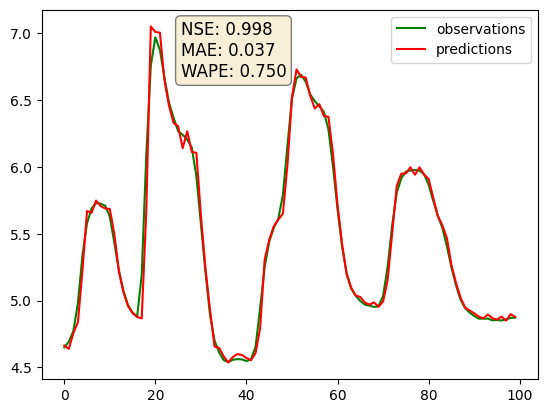

In [116]:
x = range(len(test))

# add evaluation results in the graph itself

plt.plot(np.array(test[:100]), color='green', label='observations')
plt.plot(np.array(predictions[:100]), color='red', linestyle='-', label='predictions')
metrics_text = f"NSE: {nse:.3f}\nMAE: {mae:.3f}\nWAPE: {wape:.3f}" 
plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
plt.show()